In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# !pip install vaderSentiment                # uncomment this line if vaderSentiment was not installed
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import reuters
nltk.download('reuters')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

### 24.2.3 Autoencoder vs. PCA in Practice

In 8.5.3, we showed that using top PCs can achieve good prediction results comparable with regressing on all assets. In this example, we follow the same context and show how to reduce feature dimension by using autoencoder:

In [ ]:
# load and check country/region ETF data
country_etf_tickers = [
    "EPI",        # India
    "EWC",        # Canada
    "EWG",        # Germany
    "EWH",        # Hong Kong
    "EWJ",        # Japan
    "EWU",        # United Kingdom
    "EWW",        # Mexico
    "EWY",        # South Korea
    "EWZ",        # Brazil
    "FXI",        # China
    "SPY",        # United States
]

df_etf = yf.download(country_etf_tickers, start='2016-01-01', end='2024-02-29', auto_adjust=False)['Adj Close']
df_ret = np.log(df_etf/df_etf.shift(1)).dropna()
df_ret.tail()

[*********************100%***********************]  11 of 11 completed


Ticker,EPI,EWC,EWG,EWH,EWJ,EWU,EWW,EWY,EWZ,FXI,SPY
Date,,,,,,,,,,,
2024-02-22,0.011297,0.009546,0.016358,0.002404,0.016241,0.007324,0.001191,0.012826,-0.005954,0.015145,0.020484
2024-02-23,-0.000899,0.004064,0.000662,-0.003006,0.001595,0.003642,-0.010020,0.000461,-0.011110,0.007073,0.000689
2024-02-26,-0.005185,-0.003792,0.002974,-0.004828,-0.000145,-0.003034,-0.005426,-0.014843,0.005120,-0.008745,-0.003669
2024-02-27,-0.000452,-0.002445,0.007887,0.000000,0.002605,0.000607,-0.000756,-0.009075,0.023454,0.017002,0.001856
2024-02-28,-0.013203,-0.006003,-0.001966,-0.012786,-0.007399,-0.010685,-0.018778,0.008296,-0.021653,-0.036002,-0.001323


In [ ]:
# load and check ACWI data
df_acwi = yf.download('ACWI', start='2016-01-01', end='2024-02-29', auto_adjust=False)[['Adj Close']]
df_acwi_ret = np.log(df_acwi/df_acwi.shift(1)).dropna()
df_acwi_ret.columns = ['Return']
df_acwi_ret.tail()

[*********************100%***********************]  1 of 1 completed


,Return
Date,
2024-02-22,0.017104
2024-02-23,0.000375
2024-02-26,-0.002720
2024-02-27,0.001970
2024-02-28,-0.004227


In [ ]:
# prepare lagged data
df_data_etf = df_ret.shift(1).dropna()
df_data_etf.columns = [f'{c}_lag1' for c in df_ret.columns]
df_data_acwi = df_acwi_ret.iloc[1:]

In [ ]:
# train-test split
n = len(df_data_etf)
ntrain = int(n*0.9)
X_train = df_data_etf[:ntrain]
y_train = df_data_acwi[:ntrain]
X_test = df_data_etf[ntrain:]
y_test = df_data_acwi[ntrain:]

# autoencoder
input_dim = X_train.shape[1]
encoding_dim = 3                 # subject to change
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, y_train, epochs=50, batch_size=32, shuffle=True)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2458
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2325
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2161
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1954
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1705
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1378
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1055
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0792
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0588
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0436
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252
Epoch 13/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199
Epoch 14/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158
Epoch 15/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129
Epoch 16/50
58/58 ━

In [ ]:
# get latent variables
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
# linear regression: ACWI on latent variables
regressor = LinearRegression()
regressor.fit(X_train_encoded, y_train)

y_pred_train = regressor.predict(X_train_encoded)
y_pred_test = regressor.predict(X_test_encoded)

df_pred = df_data_acwi.copy()
df_pred['Prediction'] = list(y_pred_train.reshape(-1)) + list(y_pred_test.reshape(-1))

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'Train RMSE: {rmse_train:.3f}\nTest RMSE: {rmse_test:.3f}')

Train RMSE: 0.011
Test RMSE: 0.008


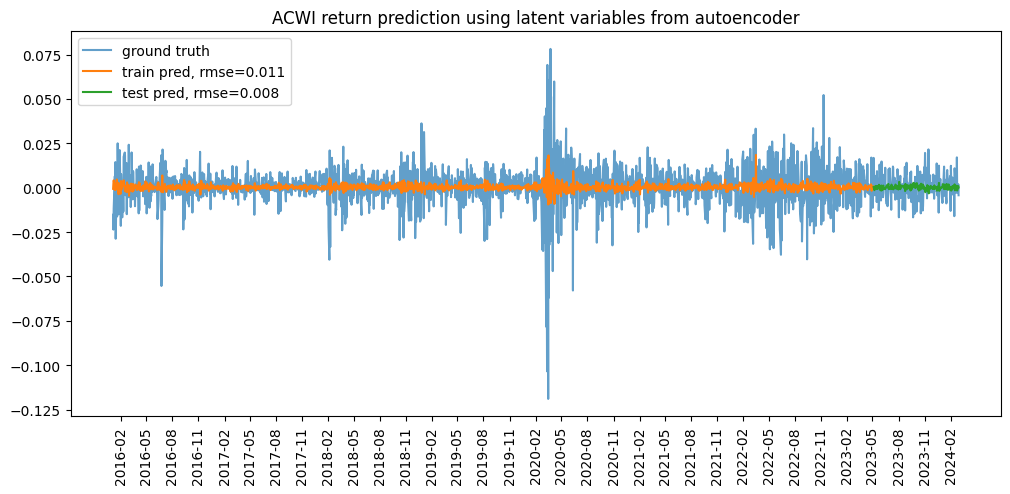

In [ ]:
# visualization
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_pred['Return'], alpha=0.7, label='ground truth')                             # ground truth
ax.plot(df_pred['Prediction'][:ntrain], label=f'train pred, rmse={rmse_train:.3f}')     # training set predictions
ax.plot(df_pred['Prediction'][ntrain:], label=f'test pred, rmse={rmse_test:.3f}')       # testing set predictions
ticks_range = pd.date_range(df_data_etf.index.min(), df_data_etf.index.max(), freq='3MS', inclusive='both')
plt.xticks(ticks_range, [str(dt.year)+'-'+str('%02d'%dt.month) for dt in ticks_range], rotation=90)
plt.title('ACWI return prediction using latent variables from autoencoder')
plt.legend()
plt.show()

Recall that the train and test RMSEs using top 1 PC (from 8.5.3) are the same as using 3 latent variables in this example. Therefore, besides PCA, autoencoder is another good dimension reduction tool for prediction tasks as such.

### 24.2.7 Deep Learning in Practice

We obtained this mortgage dataset from the book [_Credit Risk Analytics: Measurement Techniques, Applications, and Examples in SAS_](http://www.creditriskanalytics.net/) (Baesens et al., 2016). The following content is from this book's [online resource](https://www.google.com/url?q=http%3A%2F%2Fwww.creditriskanalytics.net%2Fdatasets-private2.html):

> The dataset is in panel form and reports origination and performance observations for 50,000 residential U.S. mortgage borrowers over 60 periods. The periods have been deidentified. As in the real world, loans may originate before the start of the observation period (this is an issue where loans are transferred between banks and investors as in securitization). The loan observations may thus be censored as the loans mature or borrowers refinance. The data set is a randomized selection of mortgage-loan-level data collected from the portfolios underlying U.S. residential mortgage-backed securities (RMBS) securitization portfolios and provided by [International Financial Research](www.internationalfinancialresearch.org).

*Note: If you are not running this notebook from the default GitHub directory, please download `mortgage.csv` from the `data/` folder, upload it to your current working directory, and remove `data/` from the file path.*

In [ ]:
# load data
df = pd.read_csv('data/mortgage.csv')
df.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,1,25,-7,25,113,41303.42,24.498336,9.2,226.29,2.899137,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
1,1,26,-7,25,113,41061.95,24.483867,9.2,225.10,2.151365,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
2,1,27,-7,25,113,40804.42,24.626795,9.2,222.39,2.361722,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
3,1,28,-7,25,113,40483.89,24.735883,9.2,219.67,1.229172,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
4,1,29,-7,25,113,40367.06,24.925476,9.2,217.37,1.692969,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0


We also obtained variable definitions from the the same online resource:

| Variable | Definition |
| --- | --- |
| id | Borrower ID |
| time | Time stamp of observation |
| orig_time | Time stamp for origination |
| first_time | Time stamp for first observation |
| mat_time | Time stamp for maturity |
| balance_time | Outstanding balance at observation time |
| LTV_time | Loan-to-value ratio at observation time, in % |
| interest_rate_time | Interest rate at observation time, in % |
| hpi_time | House price index at observation time, base year = 100 |
| gdp_time | Gross domestic product (GDP) growth at observation time, in % |
| uer_time | Unemployment rate at observation time, in % |
| REtype_CO_orig_time | Real estate type condominium = 1, otherwise = 0 |
| REtype_PU_orig_time | Real estate type planned urban development = 1, otherwise = 0 |
| REtype_SF_orig_time | Single-family home = 1, otherwise = 0 |
| investor_orig_time | Investor borrower = 1, otherwise = 0 |
| balance_orig_time | Outstanding balance at origination time |
| FICO_orig_time | FICO score at origination time, in % |
| LTV_orig_time | Loan-to-value ratio at origination time, in % |
| Interest_Rate_orig_time | Interest rate at origination time, in % |
| hpi_orig_time | House price index at origination time, base year = 100 |
| default_time | Default observation at observation time |
| payoff_time | Payoff observation at observation time |
| status_time | Default (1), payoff (2), and nondefault/nonpayoff (0) observation at observation time |

To simplify the problem, we focus exclusively on the most recent observation per borrower with a well-defined default status (1 or 2). We also remove records with `NaN` values.

In [ ]:
most_recent_obs = df.groupby('id')['time'].max()
df = pd.merge(df, most_recent_obs, on=['id', 'time'])
df = df[df.status_time!=0]
df = df.dropna()
df = df.reset_index(drop=True)
df

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,1,48,-7,25,113,29087.21,26.658065,9.200,146.45,2.715903,...,1,0,45000.0,715,69.4,9.200,87.03,1,0,1
1,2,26,18,25,138,105654.77,65.469851,7.680,225.10,2.151365,...,1,0,107200.0,558,80.0,7.680,186.91,0,1,2
2,3,29,-6,25,114,44378.60,31.459735,11.375,217.37,1.692969,...,1,0,48600.0,680,83.6,8.750,89.58,0,1,2
3,5,27,18,25,138,52100.71,66.346343,9.155,222.39,2.361722,...,1,0,52800.0,527,80.0,9.155,186.91,0,1,2
4,6,56,19,25,139,190474.11,75.834755,6.580,181.43,1.717053,...,1,0,212000.0,670,80.0,6.580,191.42,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41730,49967,52,25,52,145,241955.16,94.357788,7.000,161.13,1.081049,...,0,1,242000.0,691,67.2,7.000,226.29,0,1,2
41731,49970,54,25,52,145,77285.24,89.770553,7.500,179.97,1.507359,...,1,1,86600.0,672,80.0,7.500,226.29,0,1,2
41732,49972,56,25,52,145,178952.48,90.874242,7.500,181.43,1.717053,...,1,0,196000.0,708,79.8,7.500,226.29,1,0,1
41733,49983,56,14,52,134,192505.84,53.288346,6.500,181.43,1.717053,...,0,0,232000.0,665,74.8,6.500,155.77,0,1,2


Among the 22 variables except `id`, 6 are macroeconomic indicators (`interest_rate_time`, `hpi_time`, `gdp_time`, `uer_time`, `Interest_Rate_orig_time`, `hpi_orig_time`), 9 are borrower-specific indicators (`balance_time`, `LTV_time`, `REtype_CO_orig_time`, `REtype_PU_orig_time`, `REtype_SF_orig_time`, `investor_orig_time`, `balance_orig_time`, `FICO_orig_time`, `LTV_orig_time`), 3 are outcome variables (`default_time`, `payoff_time`, `status_time`), and the remaining 4 are timestamps. We will use all macroeconomic and borrower-specific indicators to predict the borrower's default status (`stauts_time`).

In [ ]:
vars = ['balance_time','LTV_time','interest_rate_time','hpi_time','gdp_time','uer_time',
        'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time','investor_orig_time',
        'balance_orig_time','FICO_orig_time','LTV_orig_time','Interest_Rate_orig_time', 'hpi_orig_time']
target = ['status_time']

ids = df.id
X = df[vars]
y = df[target].values.reshape(-1)

In [ ]:
N = len(df)
ntrain = int(N*0.8)

X_train = X[:ntrain]
y_train = y[:ntrain]
X_test = X[ntrain:]
y_test = y[ntrain:]

We build a Multi-layer Perceptron classifier using `MLPClassifier` from `sklearn`. Note that unlike the regression example in 24.6.2, this is a classification problem. As a common practice, we scale the features before feeding the to the model.

In [ ]:
# NN
cls = MLPClassifier(hidden_layer_sizes=(15,5),
                   activation='relu',
                   random_state=42)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', cls)])
pipe.fit(X_train, y_train)

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

In [ ]:
print(classification_report(y_train, y_pred_train, digits=4))

              precision    recall  f1-score   support

           1     0.7536    0.6666    0.7074     11942
           2     0.8255    0.8787    0.8513     21446

    accuracy                         0.8028     33388
   macro avg     0.7896    0.7726    0.7794     33388
weighted avg     0.7998    0.8028    0.7998     33388



In [ ]:
print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

           1     0.7542    0.6718    0.7106      3211
           2     0.8079    0.8631    0.8346      5136

    accuracy                         0.7895      8347
   macro avg     0.7811    0.7674    0.7726      8347
weighted avg     0.7872    0.7895    0.7869      8347



The classifier has a train accuracy of 0.8028 and a test accuracy of 0.7895. In other words, this classifier has a chance of 79% of making a correct prediction of a borrower's default status, given microeconomic indicators and the person's financial conditions.

On the other hand, traditional statistical models can do the same classification task. For example, we can run logistic regression on the same set of variables:

In [ ]:
logreg = LogisticRegression(max_iter=2000)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', logreg)])

pipe.fit(X_train, y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

In [ ]:
print(classification_report(y_train, y_pred_train, digits=4))

              precision    recall  f1-score   support

           1     0.7338    0.5973    0.6585     11942
           2     0.7968    0.8793    0.8360     21446

    accuracy                         0.7785     33388
   macro avg     0.7653    0.7383    0.7473     33388
weighted avg     0.7743    0.7785    0.7725     33388



In [ ]:
print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

           1     0.7499    0.6070    0.6709      3211
           2     0.7804    0.8734    0.8243      5136

    accuracy                         0.7709      8347
   macro avg     0.7652    0.7402    0.7476      8347
weighted avg     0.7687    0.7709    0.7653      8347



### 24.3.3 Natural Language Processing in Practice: Parsing News for Trading Signal

In [ ]:
# load data
categories = reuters.categories()
trade_article_ids = reuters.fileids('trade')                    # extract all articles in the 'trade' category; category is subject to change
trade_articles = [reuters.raw(trade_article_ids[i]) for i in range(len(trade_article_ids))]

In [ ]:
# sentiment analysis
analyser = SentimentIntensityAnalyzer()
scores = []

for idx, a in enumerate(trade_articles):
    score = analyser.polarity_scores(a)['compound']
    scores.append(score)
    signal = 'long' if score>0 else 'short'
    print(f'Compound sentiment of the {idx}-th article: {score:.3f}; implied trading signal: {signal}')

Compound sentiment of the 0-th article: -0.981; implied trading signal: short
Compound sentiment of the 1-th article: 0.017; implied trading signal: long
Compound sentiment of the 2-th article: 0.822; implied trading signal: long
Compound sentiment of the 3-th article: 0.562; implied trading signal: long
Compound sentiment of the 4-th article: 0.853; implied trading signal: long
Compound sentiment of the 5-th article: -0.947; implied trading signal: short
Compound sentiment of the 6-th article: 0.823; implied trading signal: long
Compound sentiment of the 7-th article: -0.265; implied trading signal: short
Compound sentiment of the 8-th article: -0.450; implied trading signal: short
Compound sentiment of the 9-th article: -0.459; implied trading signal: short
Compound sentiment of the 10-th article: 0.000; implied trading signal: short
Compound sentiment of the 11-th article: 0.612; implied trading signal: long
Compound sentiment of the 12-th article: -0.985; implied trading signal: sh

We can cross check the generated sentiment scores with articles. For example, we extract the most positive, most negative, and most neutral items and print them out:

In [ ]:
# most positive
idx_pos = np.argmax(scores)
score_pos = scores[idx_pos]
article_pos = trade_articles[idx_pos]
print(f'The most positive article with compound sentiment {score_pos}: \n  ========================= \n{article_pos}')

The most positive article with compound sentiment 0.9977: 
FEBRUARY U.S. JOBS GAINS SHOW STRONGER ECONOMY
  Momentum in th U.S. economy may be
  picking up given solid across-the board increases in the
  February U.S. employment report, economists said.
      U.S. non-farm payroll employment rose 337,000 in February,
  twice what the financial markets expected. This follows a
  319,000 gain in January, revised down from a previously
  reported 448,000 increase.
      "Even if you look at January and February together, this is
  still a much stronger report than the consensus expectation in
  the market," said Allan Leslie of Discount Corporation.
      Economists stressed that gains in hours worked signal much
  larger gains in February U.S. production and income than
  previously forecast.
      The average work week rose 0.2 hours to 35.0 hours from
  34.8 hours in January. The average manufacturing work week rose
  0.3 hours to 41.2 hours, the longest factory work week since
  Novem

In [ ]:
# most negative
idx_neg = np.argmin(scores)
score_neg = scores[idx_neg]
article_neg = trade_articles[idx_neg]
print(f'The most negative article with compound sentiment {score_neg}: \n  ========================= \n{article_neg}')

The most negative article with compound sentiment -0.9964: 
JAPANESE TARIFFS SEEN AS WORLDWIDE WARNING
  The tough trade sanctions President
  Reagan imposed on Japanese exports are not only a shot across
  Japan's bow but also a sign Reagan will attack unfair trade
  practices worldwide, U.S. officials said.
      But Robert Crandall, a trade specialist at Brookings
  Institution, a think tank, said "a shot across their bow can
  often result in a shot in our stern."
      He said it left the United States open to retaliation.
      The U.S. officials said the 100 pct tariffs Reagan ordered
  on 300 mln dlrs worth of Japanese goods will also show Congress
  that a tough pro-trade stand can be taken under existing laws,
  and no new protectionist legislation is needed.
      In the past year tough trade action had been taken against
  the European Community over corn and sorghum, Taiwan over beer
  and wine, South Korea over counterfeiting of copyrights,
  patents and trademarkets and 

In [ ]:
# most neutral
idx_neu = np.argmin(np.abs(scores))
score_neu = scores[idx_neu]
article_neu = trade_articles[idx_neu]
print(f'The most neutral article with compound sentiment {score_neu}: \n  ========================= \n{article_neu}')

The most neutral article with compound sentiment 0.0: 
CANADA PLANS TO MONITOR STEEL IMPORTS, EXPORTS, TRADE MINISTER SAYS

  CANADA PLANS TO MONITOR STEEL IMPORTS, EXPORTS, TRADE MINISTER SAYS
  


